# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '09'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedice"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedice.values
    n_s  = xr.open_dataset(fname).n_rimedice.values
    r_s  = xr.open_dataset(fname).rime_rimedice.values
    v_s  = xr.open_dataset(fname).rvol_rimedice.values
    # process rates
    vel_num  = xr.open_dataset(fname).rimedice_vel_num.values
    vel_mass = xr.open_dataset(fname).rimedice_vel_mass.values
    vel_rime = xr.open_dataset(fname).rimedice_vel_rime.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    vel_num  = np.log(vel_num,  where=vel_num>p_min, out=np.nan*vel_num)    
    vel_mass = np.log(vel_mass, where=vel_mass>p_min, out=np.nan*vel_mass)
    vel_rime = np.log(vel_rime, where=vel_rime>p_min, out=np.nan*vel_rime)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, temp, rho, vel_num, vel_mass, vel_rime ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'temp', 'rho', 'vel_num', 'vel_mass', 'vel_rime' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

q_s            n_s            r_s            v_s  \
count  262632.000000  262632.000000  262632.000000  262632.000000   
mean      -12.166051       7.182906     -13.320219     -18.655182   
std         2.555933       2.717398       2.767870       2.823814   
min       -22.398951     -14.498609     -22.608919     -27.630821   
25%       -13.693205       5.711685     -15.017660     -20.385937   
50%       -12.094987       7.334786     -13.267910     -18.603462   
75%       -10.338549       8.977478     -11.424548     -16.747011   
max        -4.456319      16.136034      -4.653678     -11.166290   

                temp            rho        vel_num       vel_mass  \
count  262632.000000  262632.000000  262632.000000  262632.000000   
mean      264.176941       0.996563      -1.013966      -0.847452   
std         7.569832       0.122769       0.540861       0.542233   
min       245.690002       0.711000      -3.274653      -3.274653   
25%       258.079987       0.896000      -1.338743      -1.185805   
50%       265.320007       1.004000      -1.034230      -0.864410   
75%       271.100006       1.098000      -0.750988      -0.536656   
max       282.420013       1.288000       3.895080       3.895080   

            vel_rime  
count  262632.000000  
mean       -0.682846  
std         0.520496  
min        -3.274653  
25%        -1.000828  
50%        -0.674718  
75%        -0.363124  
max         3.895080

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s        temp    rho   vel_num  \
0  -11.834965  7.581669 -16.452967 -21.468021  265.890015  1.038 -1.144447   
1  -11.692698  7.744050 -15.343876 -20.366152  265.950012  1.039 -1.149800   
4  -11.591861  7.757564 -14.299613 -19.343794  266.140015  1.042 -1.107149   
6  -11.541376  7.747640 -13.978606 -19.037312  266.279999  1.044 -1.079104   
10 -11.458058  7.722102 -13.607846 -18.695921  266.549988  1.049 -1.031141   

    vel_mass  vel_rime  
0  -1.077928 -1.064501  
1  -1.076753 -1.042988  
4  -1.031141 -0.995063  
6  -1.003484 -0.968374  
10 -0.957634 -0.921806

In [11]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  184086.000000  184086.000000  184086.000000  184086.000000   
mean      -12.163770       7.186121     -13.317830     -18.652822   
std         2.556339       2.713279       2.767710       2.824219   
min       -22.398951     -14.498609     -22.608919     -27.630821   
25%       -13.690708       5.716361     -15.019833     -20.387561   
50%       -12.089837       7.336937     -13.264071     -18.599036   
75%       -10.331842       8.979889     -11.418275     -16.742212   
max        -4.456319      16.136034      -4.653678     -11.166290   

                temp            rho        vel_num       vel_mass  \
count  184086.000000  184086.000000  184086.000000  184086.000000   
mean      264.177032       0.996502      -1.014169      -0.847579   
std         7.563560       0.122662       0.540037       0.541586   
min       245.690002       0.711000      -3.052938      -3.046605   
25%       258.089996       0.896000      -1.338266      -1.185478   
50%       265.309998       1.004000      -1.033949      -0.863936   
75%       271.089996       1.098000      -0.751200      -0.536827   
max       282.420013       1.288000       3.895080       3.895080   

            vel_rime  
count  184086.000000  
mean       -0.682911  
std         0.519901  
min        -3.046605  
25%        -1.000760  
50%        -0.673933  
75%        -0.363268  
max         3.895080

In [12]:
dataset_test.describe()

q_s           n_s           r_s           v_s          temp  \
count  39298.000000  39298.000000  39298.000000  39298.000000  39298.000000   
mean     -12.172600      7.168283    -13.333829    -18.668781    264.197876   
std        2.552956      2.733476      2.769981      2.824596      7.605226   
min      -22.256207    -14.498609    -22.557537    -27.628424    245.759995   
25%      -13.708968      5.687323    -15.015549    -20.385348    258.029999   
50%      -12.118905      7.307806    -13.288890    -18.629392    265.429993   
75%      -10.361041      8.969726    -11.449153    -16.767600    271.160004   
max       -4.695763     16.058048     -4.939189    -11.276195    282.200012   

                rho       vel_num      vel_mass      vel_rime  
count  39298.000000  39298.000000  39298.000000  39298.000000  
mean       0.996991     -1.010585     -0.844508     -0.679669  
std        0.123127      0.544767      0.544930      0.522671  
min        0.712000     -3.110470     -3.110470     -3.141221  
25%        0.895000     -1.337504     -1.184170     -0.997772  
50%        1.006000     -1.034793     -0.864648     -0.676487  
75%        1.099000     -0.749506     -0.537683     -0.361687  
max        1.285000      3.713816      3.714060      3.714060

In [13]:
dataset_val.describe()

q_s           n_s           r_s           v_s          temp  \
count  39248.000000  39248.000000  39248.000000  39248.000000  39248.000000   
mean     -12.170214      7.182469    -13.317801    -18.652609    264.155579   
std        2.557059      2.720577      2.766540      2.821163      7.563848   
min      -22.098423    -14.498609    -22.483294    -27.620180    245.729996   
25%      -13.690156      5.714376    -15.009392    -20.376296    258.070007   
50%      -12.094683      7.336937    -13.264561    -18.600394    265.260010   
75%      -10.354277      8.973427    -11.428010    -16.749338    271.059998   
max       -4.587920     16.019291     -4.810781    -11.386909    282.250000   

                rho       vel_num      vel_mass      vel_rime  
count  39248.000000  39248.000000  39248.000000  39248.000000  
mean       0.996420     -1.016394     -0.849810     -0.685724  
std        0.122913      0.540794      0.542560      0.521097  
min        0.713000     -3.274653     -3.274653     -3.274653  
25%        0.896000     -1.343618     -1.189413     -1.004644  
50%        1.004000     -1.034511     -0.866549     -0.675897  
75%        1.097000     -0.750564     -0.535118     -0.364131  
max        1.287000      3.797734      3.797734      3.797734

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['n_s'] < -10 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  152090.000000  152090.000000  152090.000000  152090.000000   
mean      -12.004326       7.567204     -13.092221     -18.384272   
std         2.472001       2.426283       2.626413       2.658627   
min       -19.999880      -2.949555     -22.608919     -27.623251   
25%       -13.590369       6.060792     -14.820018     -20.150028   
50%       -11.974921       7.582255     -13.103149     -18.406038   
75%       -10.212325       9.244717     -11.280149     -16.578592   
max        -5.269536      16.136034      -5.991785     -11.166290   

                temp            rho        vel_num       vel_mass  \
count  152090.000000  152090.000000  152090.000000  152090.000000   
mean      262.250549       0.965600      -1.141457      -0.965289   
std         6.889761       0.110213       0.413285       0.444559   
min       245.690002       0.711000      -3.046605      -3.046605   
25%       256.630005       0.875000      -1.391910      -1.242367   
50%       263.100006       0.969000      -1.103223      -0.939815   
75%       268.140015       1.054000      -0.860620      -0.660486   
max       273.000000       1.283000       0.283674       0.722220   

            vel_rime  
count  152090.000000  
mean       -0.792116  
std         0.437711  
min        -3.046605  
25%        -1.060161  
50%        -0.750988  
75%        -0.474654  
max         0.609766

In [17]:
dataset_test.describe()

q_s           n_s           r_s           v_s          temp  \
count  32373.000000  32373.000000  32373.000000  32373.000000  32373.000000   
mean     -12.016145      7.557225    -13.107325    -18.398600    262.237610   
std        2.467665      2.429324      2.622850      2.653641      6.928946   
min      -19.993015     -1.875815    -22.557537    -27.590744    245.759995   
25%      -13.612488      6.038324    -14.818967    -20.149128    256.559998   
50%      -12.015552      7.559403    -13.138442    -18.439915    263.119995   
75%      -10.242687      9.228376    -11.304205    -16.610886    268.200012   
max       -5.333592     16.058048     -6.099495    -11.276195    273.000000   

                rho       vel_num      vel_mass      vel_rime  
count  32373.000000  32373.000000  32373.000000  32373.000000  
mean       0.965658     -1.142415     -0.966301     -0.792667  
std        0.110691      0.412393      0.443158      0.436205  
min        0.712000     -3.110470     -3.110470     -3.141221  
25%        0.874000     -1.393923     -1.242714     -1.059872  
50%        0.970000     -1.104128     -0.944433     -0.754385  
75%        1.055000     -0.862276     -0.662036     -0.478036  
max        1.279000      0.172271      0.448525      0.446607

### Pairplot

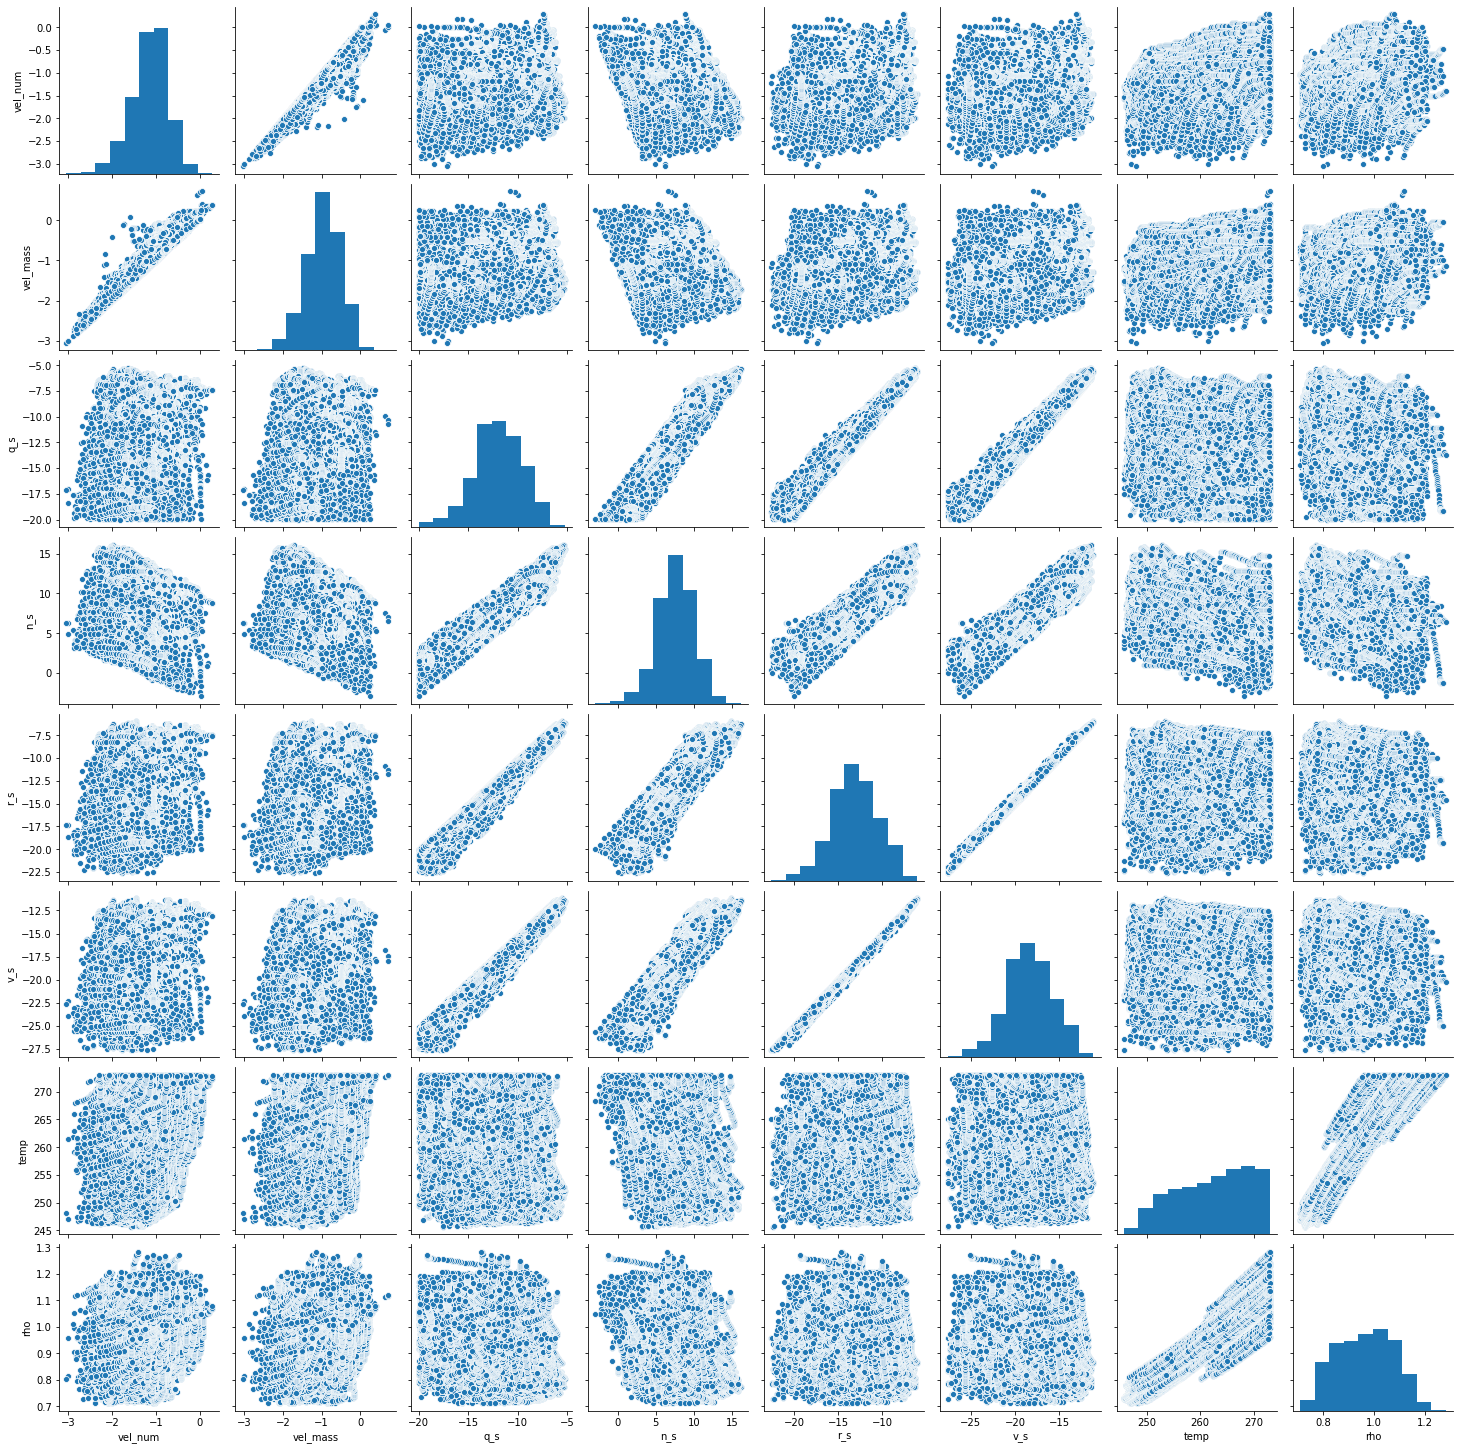

In [19]:
sns.pairplot(dataset_train[["vel_num","vel_mass","q_s","n_s","r_s","v_s","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [21]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [22]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [23]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [24]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [25]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [26]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("vel_num")
train_stats1.pop("vel_mass")
train_stats1.pop("vel_rime")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  152090.0 -12.004326  2.472001 -19.999880 -13.590369 -11.974921   
n_s  152090.0   7.567204  2.426283  -2.949555   6.060792   7.582255   
r_s  152090.0 -13.092221  2.626413 -22.608919 -14.820018 -13.103149   
v_s  152090.0 -18.384272  2.658627 -27.623251 -20.150028 -18.406038   

           75%        max  
q_s -10.212325  -5.269536  
n_s   9.244717  16.136034  
r_s -11.280149  -5.991785  
v_s -16.578592 -11.166290

In [27]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("vel_num")
train_stats2.pop("vel_mass")
train_stats2.pop("vel_rime")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  152090.0 -12.004326  2.472001 -19.999880 -13.590369 -11.974921   
n_s  152090.0   7.567204  2.426283  -2.949555   6.060792   7.582255   
r_s  152090.0 -13.092221  2.626413 -22.608919 -14.820018 -13.103149   
v_s  152090.0 -18.384272  2.658627 -27.623251 -20.150028 -18.406038   
rho  152090.0   0.965600  0.110213   0.711000   0.875000   0.969000   

           75%        max  
q_s -10.212325  -5.269536  
n_s   9.244717  16.136034  
r_s -11.280149  -5.991785  
v_s -16.578592 -11.166290  
rho   1.054000   1.283000

In [28]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("vel_num")
train_stats3.pop("vel_mass")
train_stats3.pop("vel_rime")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   152090.0  -12.004326  2.472001  -19.999880  -13.590369  -11.974921   
n_s   152090.0    7.567204  2.426283   -2.949555    6.060792    7.582255   
r_s   152090.0  -13.092221  2.626413  -22.608919  -14.820018  -13.103149   
v_s   152090.0  -18.384272  2.658627  -27.623251  -20.150028  -18.406038   
temp  152090.0  262.250549  6.889761  245.690002  256.630005  263.100006   
rho   152090.0    0.965600  0.110213    0.711000    0.875000    0.969000   

             75%         max  
q_s   -10.212325   -5.269536  
n_s     9.244717   16.136034  
r_s   -11.280149   -5.991785  
v_s   -16.578592  -11.166290  
temp  268.140015  273.000000  
rho     1.054000    1.283000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['vel_num','vel_mass','vel_rime']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_labels.describe()

vel_num       vel_mass       vel_rime
count  152090.000000  152090.000000  152090.000000
mean       -1.141457      -0.965289      -0.792116
std         0.413285       0.444559       0.437711
min        -3.046605      -3.046605      -3.046605
25%        -1.391910      -1.242367      -1.060161
50%        -1.103223      -0.939815      -0.750988
75%        -0.860620      -0.660486      -0.474654
max         0.283674       0.722220       0.609766

In [33]:
train_dataset1.describe()

q_s            n_s            r_s            v_s
count  152090.000000  152090.000000  152090.000000  152090.000000
mean      -12.004326       7.567204     -13.092221     -18.384272
std         2.472001       2.426283       2.626413       2.658627
min       -19.999880      -2.949555     -22.608919     -27.623251
25%       -13.590369       6.060792     -14.820018     -20.150028
50%       -11.974921       7.582255     -13.103149     -18.406038
75%       -10.212325       9.244717     -11.280149     -16.578592
max        -5.269536      16.136034      -5.991785     -11.166290

In [34]:
train_dataset2.describe()

q_s            n_s            r_s            v_s  \
count  152090.000000  152090.000000  152090.000000  152090.000000   
mean      -12.004326       7.567204     -13.092221     -18.384272   
std         2.472001       2.426283       2.626413       2.658627   
min       -19.999880      -2.949555     -22.608919     -27.623251   
25%       -13.590369       6.060792     -14.820018     -20.150028   
50%       -11.974921       7.582255     -13.103149     -18.406038   
75%       -10.212325       9.244717     -11.280149     -16.578592   
max        -5.269536      16.136034      -5.991785     -11.166290   

                 rho  
count  152090.000000  
mean        0.965600  
std         0.110213  
min         0.711000  
25%         0.875000  
50%         0.969000  
75%         1.054000  
max         1.283000

In [35]:
train_dataset3.describe()

q_s            n_s            r_s            v_s  \
count  152090.000000  152090.000000  152090.000000  152090.000000   
mean      -12.004326       7.567204     -13.092221     -18.384272   
std         2.472001       2.426283       2.626413       2.658627   
min       -19.999880      -2.949555     -22.608919     -27.623251   
25%       -13.590369       6.060792     -14.820018     -20.150028   
50%       -11.974921       7.582255     -13.103149     -18.406038   
75%       -10.212325       9.244717     -11.280149     -16.578592   
max        -5.269536      16.136034      -5.991785     -11.166290   

                temp            rho  
count  152090.000000  152090.000000  
mean      262.250549       0.965600  
std         6.889761       0.110213  
min       245.690002       0.711000  
25%       256.630005       0.875000  
50%       263.100006       0.969000  
75%       268.140015       1.054000  
max       273.000000       1.283000

### Normalize the features

In [36]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [37]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  152090.0  2.383408e-07  1.0 -3.234446 -0.641603  0.011895  0.724919   
n_s  152090.0 -9.635078e-08  1.0 -4.334515 -0.620872  0.006203  0.691393   
r_s  152090.0 -8.366490e-07  1.0 -3.623458 -0.657854 -0.004161  0.689942   
v_s  152090.0  3.396736e-07  1.0 -3.475094 -0.664161 -0.008187  0.679177   

          max  
q_s  2.724429  
n_s  3.531670  
r_s  2.703473  
v_s  2.714928

In [38]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  152090.0  2.383408e-07  1.0 -3.234446 -0.641603  0.011895  0.724919   
n_s  152090.0 -9.635078e-08  1.0 -4.334515 -0.620872  0.006203  0.691393   
r_s  152090.0 -8.366490e-07  1.0 -3.623458 -0.657854 -0.004161  0.689942   
v_s  152090.0  3.396736e-07  1.0 -3.475094 -0.664161 -0.008187  0.679177   
rho  152090.0 -3.120238e-07  1.0 -2.310067 -0.822044  0.030848  0.802080   

          max  
q_s  2.724429  
n_s  3.531670  
r_s  2.703473  
v_s  2.714928  
rho  2.879869

In [39]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   152090.0  2.383408e-07  1.0 -3.234446 -0.641603  0.011895  0.724919   
n_s   152090.0 -9.635078e-08  1.0 -4.334515 -0.620872  0.006203  0.691393   
r_s   152090.0 -8.366490e-07  1.0 -3.623458 -0.657854 -0.004161  0.689942   
v_s   152090.0  3.396736e-07  1.0 -3.475094 -0.664161 -0.008187  0.679177   
temp  152090.0 -2.494670e-06  1.0 -2.403646 -0.815782  0.123293  0.854814   
rho   152090.0 -3.120238e-07  1.0 -2.310067 -0.822044  0.030848  0.802080   

           max  
q_s   2.724429  
n_s   3.531670  
r_s   2.703473  
v_s   2.714928  
temp  1.560207  
rho   2.879869

### Normalize the labels

In [40]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   152090.0 -1.141457  0.413285 -3.046605 -1.391910 -1.103223   
vel_mass  152090.0 -0.965289  0.444559 -3.046605 -1.242367 -0.939815   
vel_rime  152090.0 -0.792116  0.437711 -3.046605 -1.060161 -0.750988   

               75%       max  
vel_num  -0.860620  0.283674  
vel_mass -0.660486  0.722220  
vel_rime -0.474654  0.609766

In [41]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [42]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(3)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [43]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 675
Trainable params: 675
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [45]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.6884605 , -0.57186204, -0.7270155 ],
       [-0.68951887, -0.5753417 , -0.7304936 ],
       [-0.69023216, -0.5786774 , -0.7340897 ],
       [-0.6904316 , -0.57970226, -0.7351969 ],
       [-0.690657  , -0.58085924, -0.7364531 ],
       [-0.69069296, -0.58104014, -0.73665035],
       [-0.6907234 , -0.5811912 , -0.73681426],
       [-0.690747  , -0.5813136 , -0.736951  ],
       [-0.6907845 , -0.5815049 , -0.7371646 ],
       [-0.69079715, -0.5815721 , -0.7372418 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [46]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [47]:
activ = "ReLU"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0709,  mae:0.1747,  mse:0.0709,  val_loss:0.0371,  val_mae:0.1359,  val_mse:0.0371,  
.....................................................

Text(0, 0.5, 'MAE')

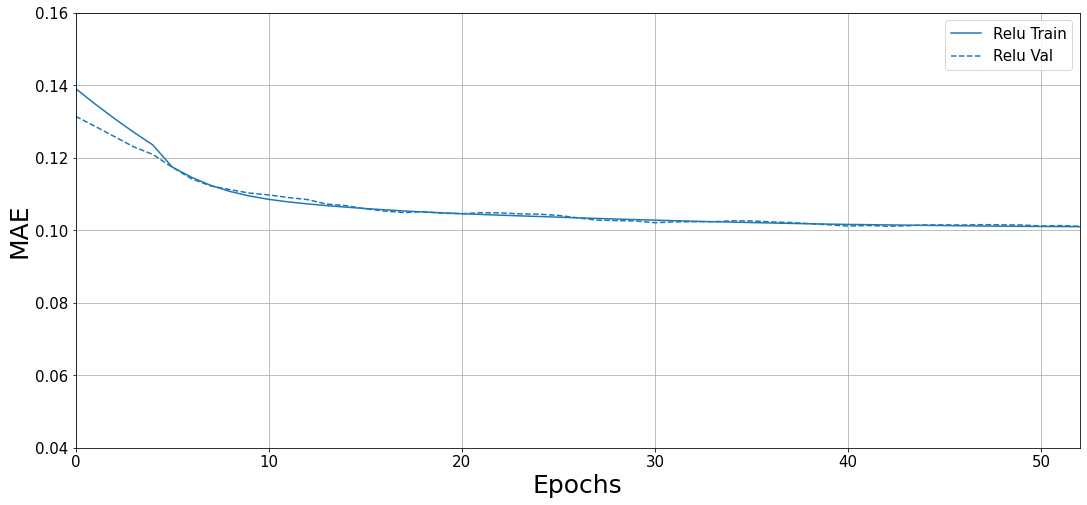

In [50]:
histories['ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04,0.16])
plt.ylabel('MAE')

In [51]:
activ = "ReLU_Adam"
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0724,  mae:0.1774,  mse:0.0724,  val_loss:0.0364,  val_mae:0.1366,  val_mse:0.0364,  
........................................

Text(0, 0.5, 'MAE')

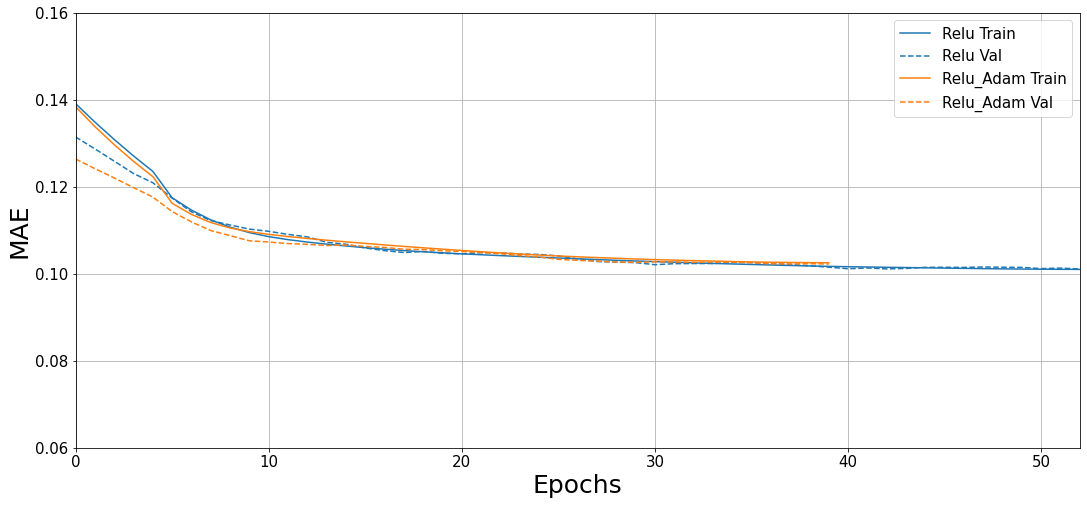

In [52]:
histories['ReLU_Adam'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.16])
plt.ylabel('MAE')

In [53]:
nsize = 32
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0602,  mae:0.1644,  mse:0.0602,  val_loss:0.0354,  val_mae:0.1355,  val_mse:0.0354,  
....................................................................................................
Epoch: 100, loss:0.0179,  mae:0.0879,  mse:0.0179,  val_loss:0.0186,  val_mae:0.0891,  val_mse:0.0186,  
..

Text(0, 0.5, 'MAE')

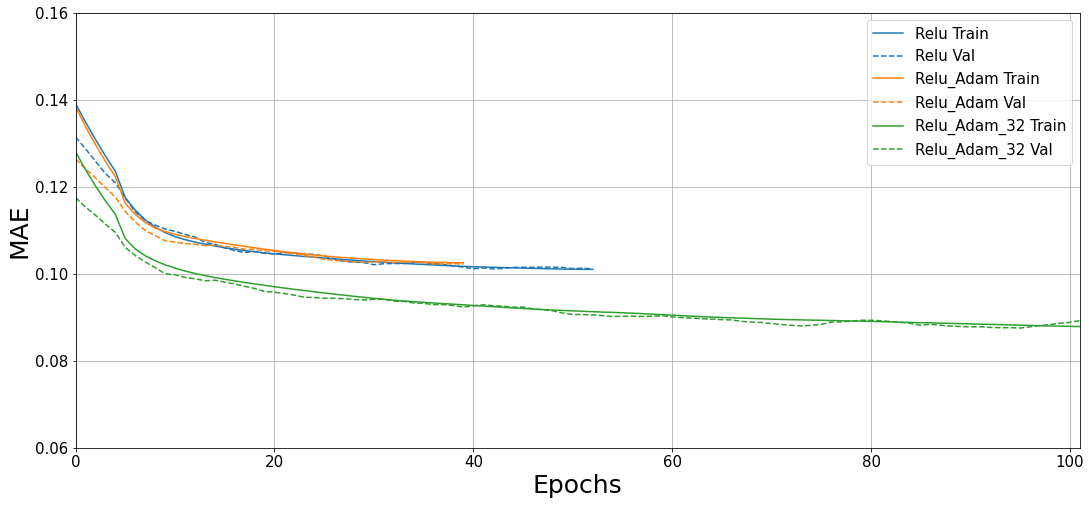

In [54]:
histories['ReLU_Adam_32'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.16])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

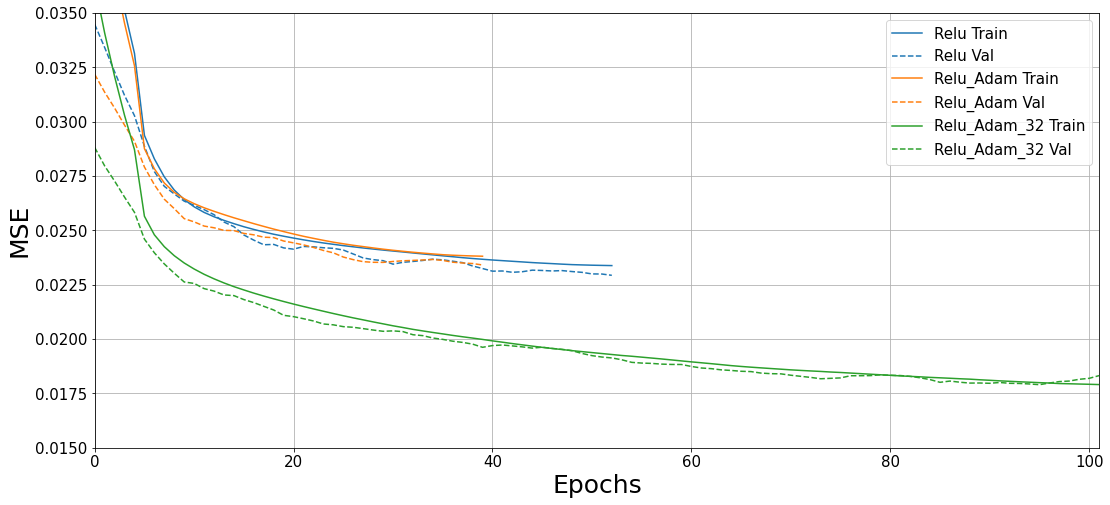

In [56]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.015, 0.035])
plt.ylabel('MSE')

In [57]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

32373/32373 - 1s - loss: 0.0228 - mae: 0.1002 - mse: 0.0228
Testing set for model 1, Mean Abs Error:    0.10018


In [58]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

32373/32373 - 1s - loss: 0.0230 - mae: 0.1015 - mse: 0.0230
Testing set for model 2, Mean Abs Error:              0.10147


In [59]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

32373/32373 - 1s - loss: 0.0177 - mae: 0.0863 - mse: 0.0177
Testing set for model 3, Mean Abs Error:              0.08633


In [60]:
mae = [ mae1, mae2, mae3 ]
mae

[0.10017659, 0.101474, 0.08632805]

In [61]:
mse = [ mse1, mse2, mse3 ]
mse

[0.02277202, 0.0230368, 0.017658152]

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n ReLU',
 'model 2:\n ReLU_Adam',
 'model 3:\n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [63]:
test_true_num  = np.exp(test_labels.pop('vel_num'))
test_true_mass = np.exp(test_labels.pop('vel_mass'))

In [64]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [65]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime"])

In [66]:
p1.describe()

vel_num      vel_mass      vel_rime
count  32373.000000  32373.000000  32373.000000
mean       0.008439      0.003497      0.001459
std        0.991581      0.999778      0.979651
min       -4.479639     -4.521272     -4.955646
25%       -0.595096     -0.624648     -0.583110
50%        0.100073      0.062220      0.111005
75%        0.690050      0.693590      0.722174
max        3.097726      2.920879      2.533873

In [67]:
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   152090.0 -1.141457  0.413285 -3.046605 -1.391910 -1.103223   
vel_mass  152090.0 -0.965289  0.444559 -3.046605 -1.242367 -0.939815   
vel_rime  152090.0 -0.792116  0.437711 -3.046605 -1.060161 -0.750988   

               75%       max  
vel_num  -0.860620  0.283674  
vel_mass -0.660486  0.722220  
vel_rime -0.474654  0.609766

In [68]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [69]:
test_predict1.describe()

vel_num      vel_mass      vel_rime
count  32373.000000  32373.000000  32373.000000
mean       0.347055      0.419138      0.493216
std        0.136999      0.181084      0.194396
min        0.050146      0.051034      0.051754
25%        0.249724      0.288523      0.350866
50%        0.332838      0.391556      0.475434
75%        0.424743      0.518432      0.621256
max        1.148878      1.395447      1.372986

In [70]:
test_predict1_num  = test_predict1['vel_num']
test_predict1_mass = test_predict1['vel_mass']

In [71]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['vel_num']
test_predict2_mass = test_predict2['vel_mass']

In [72]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['vel_num']
test_predict3_mass = test_predict3['vel_mass']

### Maybe the ordering of the arrays is different? 

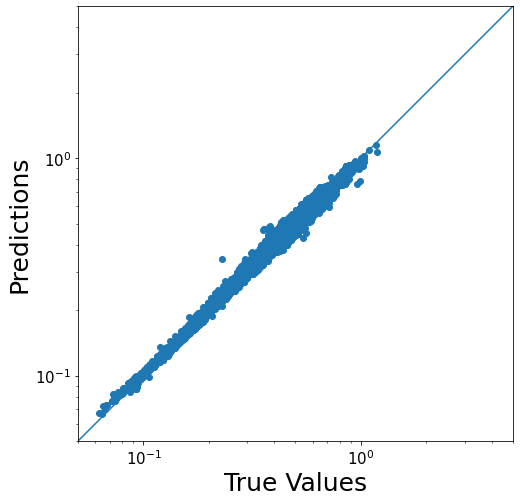

In [73]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 5e-2, 5

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

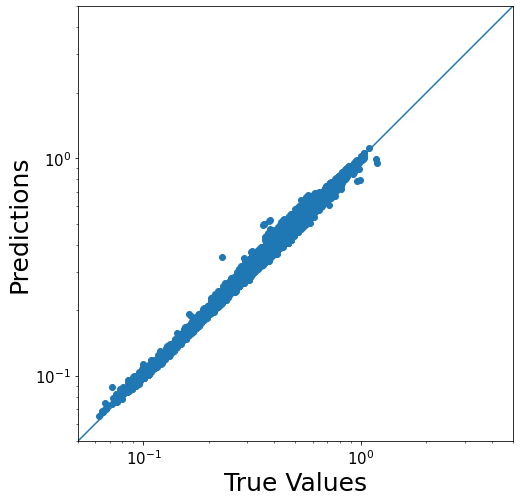

In [74]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [75]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [76]:
amin, amax = 5e-2, 5

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

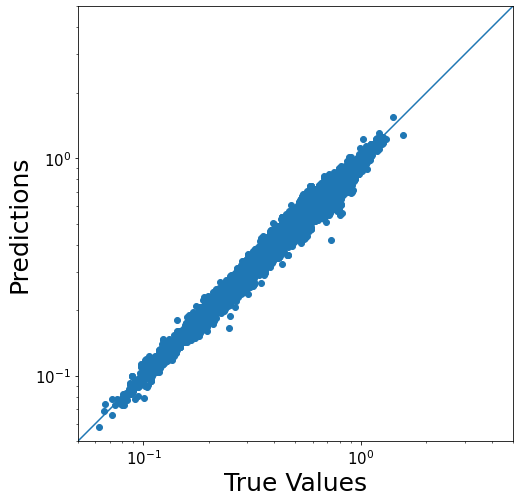

In [77]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

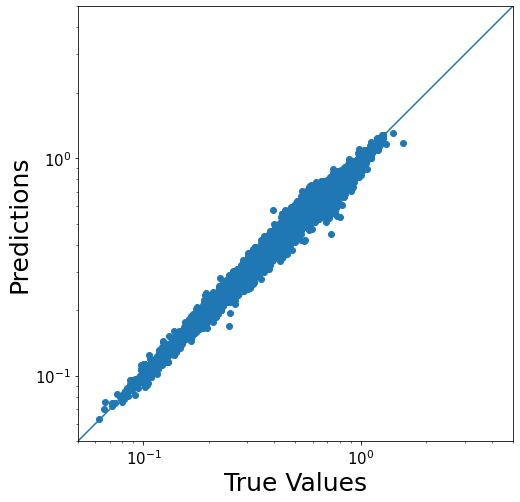

In [78]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [79]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [80]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [81]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho'
labels   = 'vel_rimesnow_num, vel_rimesnow_mass, vel_rimedice_rime'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
filename = 'saved_model_v2/vel_rimedice_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/vel_rimedice_model1_09.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_rimedice_rime
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 3), Activation: linear


In [82]:
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_rimedice_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_rimedice_model3_'+version+'.nc')


Saving model to saved_model_v2/vel_rimedice_model2_09.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_rimedice_rime
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 3), Activation: linear
Saving model to saved_model_v2/vel_rimedice_model3_09.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_rimedice_rime
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.la